<a href="https://colab.research.google.com/github/AditMeh/deep-learning/blob/main/Semantic%20Segmentation/Semantic_segmentation_drone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

In [ ]:
import tensorflow as tf
import keras
from keras.layers import Conv2D, MaxPool2D, Add, Input, Conv2DTranspose, concatenate
from keras.models import Model
from keras.optimizers import Adam
from keras.activations import softmax


path = "/content/drive/MyDrive/resized_dataset"

def train_data_generator():
    images = os.listdir(os.path.join(path, "original_images"))[:100]
    for img in images:
    
        curr_img = cv2.imread(os.path.join(path, "original_images", img), 
                              cv2.IMREAD_UNCHANGED)

        curr_mask_folder = os.path.join(path, "masks", img.split(".")[0])
        
        # print([os.path.join(curr_mask_folder, mask) for mask in os.listdir(curr_mask_folder)])

        mask_list = [cv2.imread(os.path.join(curr_mask_folder, mask), cv2.IMREAD_GRAYSCALE)/255 
        for mask in os.listdir(curr_mask_folder)]

        probability_maps = np.dstack(mask_list)
        yield (tf.convert_to_tensor(curr_img, dtype="float"), tf.convert_to_tensor(probability_maps, dtype="float"))

train_data = tf.data.Dataset.from_generator(generator=train_data_generator,
                                            output_signature=(
                                            tf.TensorSpec(shape = (400, 400, 3), dtype = tf.float32),
                                            tf.TensorSpec(shape= (400, 400, 2), dtype=tf.float32))).batch(10, drop_remainder = False).repeat(5)

In [ ]:
temp = next(train_data.as_numpy_iterator())

print(temp[0].shape)
print(temp[1].shape)

(10, 400, 400, 3)
(10, 400, 400, 2)


In [ ]:
# Define model:

class ConvBlock(keras.layers.Layer):
    def __init__(self, filters, padding = "same"):
        super().__init__()

        self.conv1 = Conv2D(filters, kernel_size = (3,3),
                            padding = padding,
                            activation = "relu",
                            data_format = "channels_last",
                            kernel_initializer = "GlorotNormal")

        self.conv2 = Conv2D(filters, kernel_size = (3,3),
                            padding = padding,
                            activation = "relu",
                            data_format = "channels_last",
                            kernel_initializer = "GlorotNormal")
    def call(self, X):
        conv1 = self.conv1(X)
        conv2 = self.conv2(conv1)
        return conv2

def build_unet():
        inp = Input(shape = (400, 400, 3))


        # Downsampling path
        conv1 = ConvBlock(64, "same")(inp)

        pool1 = MaxPool2D(pool_size= (2,2))(conv1)

        conv2 = ConvBlock(128, "same")(pool1)

        pool2 = MaxPool2D(pool_size= (2,2))(conv2)

        conv3 = ConvBlock(256, "same")(pool2)

        pool3 = MaxPool2D(pool_size= (2,2))(conv3)

        conv4 = ConvBlock(512, "same")(pool3)

        pool4 = MaxPool2D(pool_size= (2,2))(conv4)

        conv5 = ConvBlock(1024, "same")(pool4)

        #Upsampling path

        upConv1 = Conv2DTranspose(filters=512, kernel_size=(2,2), strides=(2,2), padding = "same")(conv5)
        concat1 = concatenate([upConv1, conv4], axis=3)
        conv6 = ConvBlock(512)(concat1)

        upConv2 = Conv2DTranspose(filters=256, kernel_size=(2,2), strides=(2,2), padding = "same")(conv6)
        concat2 = concatenate([upConv2, conv3], axis=3)
        conv7 = ConvBlock(256)(concat2)

        upConv3 = Conv2DTranspose(filters=128, kernel_size=(2,2), strides=(2,2), padding = "same")(conv7)
        concat3 = concatenate([upConv3, conv2], axis=3)
        conv8 = ConvBlock(64)(concat3)

        upConv4 = Conv2DTranspose(filters=64, kernel_size=(2,2), strides=(2,2), padding = "same")(conv8)
        concat4 = concatenate([upConv4, conv1], axis=3)
        conv9 = ConvBlock(64)(concat4)

        conv10 = Conv2D(2, kernel_size = (3,3),
                        padding = "same",
                        activation = "relu",
                        data_format = "channels_last",
                        kernel_initializer = "GlorotNormal")(conv9)
        
        final = softmax(conv10, axis = 3)

        model = Model(inputs = inp, outputs = final)

        model.compile(optimizer = Adam(lr = 1e-4), loss = ['categorical_crossentropy'], metrics = ['accuracy'])

        return model

In [ ]:
model = build_unet()

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 400, 400, 3) 0                                            
__________________________________________________________________________________________________
conv_block_9 (ConvBlock)        (None, 400, 400, 64) 38720       input_2[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_4 (MaxPooling2D)  (None, 200, 200, 64) 0           conv_block_9[0][0]               
__________________________________________________________________________________________________
conv_block_10 (ConvBlock)       (None, 200, 200, 128 221440      max_pooling2d_4[0][0]            
____________________________________________________________________________________________

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
history = model.fit(train_data, 
                    epochs = 5, steps_per_epoch = 10)

Epoch 1/5
10/10 [==============================] - 13s 1s/step - loss: 0.0131 - accuracy: 0.9877
Epoch 2/5
10/10 [==============================] - 14s 1s/step - loss: 0.0131 - accuracy: 0.9877
Epoch 3/5
10/10 [==============================] - 13s 1s/step - loss: 0.0131 - accuracy: 0.9877
Epoch 4/5
10/10 [==============================] - 13s 1s/step - loss: 0.0131 - accuracy: 0.9877
Epoch 5/5
10/10 [==============================] - 13s 1s/step - loss: 0.0131 - accuracy: 0.9877


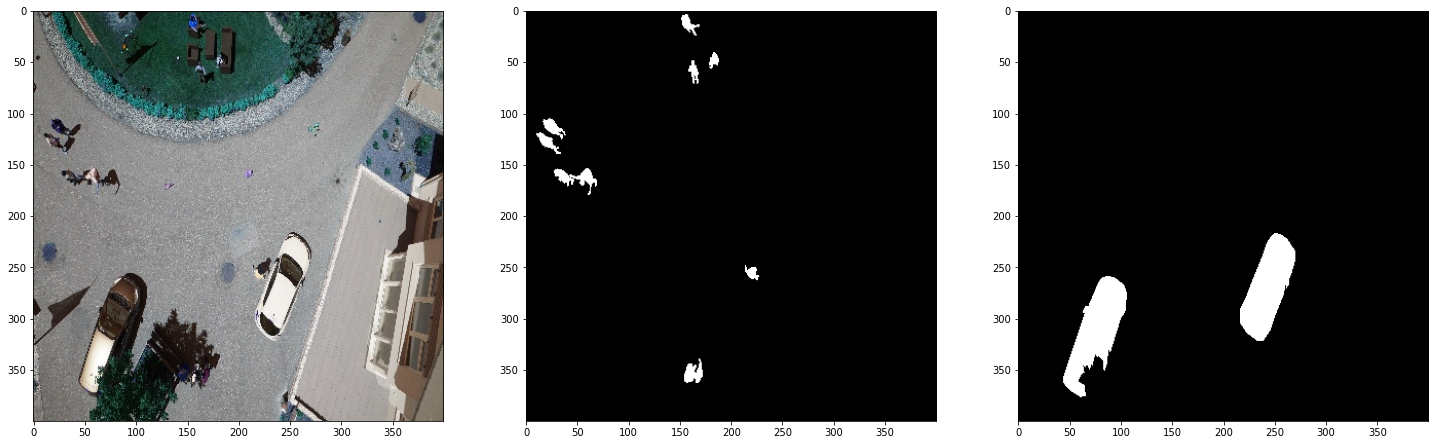

In [ ]:
path = "/content/drive/MyDrive/resized_dataset"

dataset = []

sample_image = os.path.join(os.path.join(path, "original_images"), "022.jpg")
sample_mask_person = os.path.join(os.path.join(path, "masks"), "022/15.png")
sample_mask_car = os.path.join(os.path.join(path, "masks"), "022/17.png")

image = cv2.imread(sample_image) 
person_mask = cv2.imread(sample_mask_person)
car_mask = cv2.imread(sample_mask_car)



fig=plt.figure(figsize=(25, 25))
columns = 3
rows = 1

fig.add_subplot(rows, columns, 1)
plt.imshow(image)

fig.add_subplot(rows, columns, 2)
plt.imshow(person_mask, cmap="gray")

fig.add_subplot(rows, columns, 3)
plt.imshow(car_mask, cmap="gray")


plt.show()

In [ ]:
image = np.expand_dims(image, axis= 0)
print(image.shape)
pred_image = model.predict(image)
squeezed_maps = np.squeeze(pred_image)

person_pred_mask = np.where(squeezed_maps[:, :, 0] > 0.5, 255, 0)


car_pred_mask = np.where(squeezed_maps[:, :, 1] > 0.5, 255, 0)

(1, 400, 400, 3)


In [ ]:
print(np.unique(car_pred_mask))
print(np.unique(person_pred_mask))

[  0 255]
[0]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


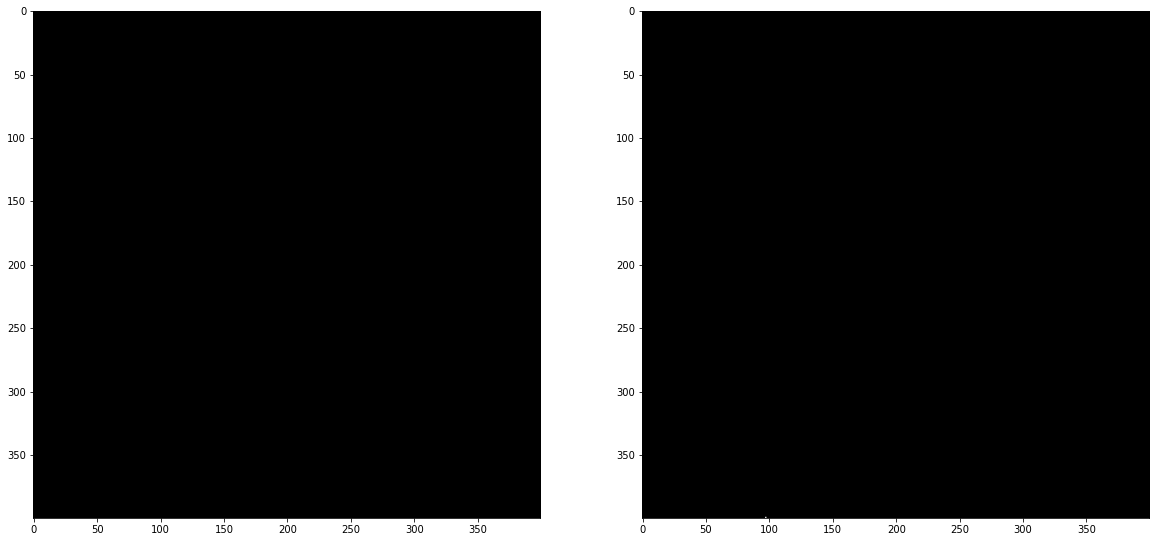

In [ ]:
fig=plt.figure(figsize=(20, 20))
columns = 2
rows = 1


fig.add_subplot(rows, columns, 1)
plt.imshow(person_pred_mask, cmap="gray")

fig.add_subplot(rows, columns, 2)
plt.imshow(car_pred_mask, cmap="gray")

plt.show()

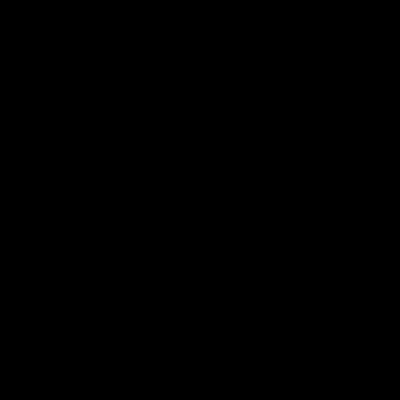

In [ ]:
from google.colab.patches import cv2_imshow
cv2_imshow(person_pred_mask)

In [ ]:
item = np.argmax(item, axis = 2)


[[17  8  8 ...  5  1 16]
 [ 2  8  8 ...  1 15 15]
 [ 2  8  8 ...  8  8  0]
 ...
 [ 9  8  8 ...  8  8 15]
 [ 9  9  8 ...  8  8  0]
 [ 9  9  0 ... 14 14  8]]


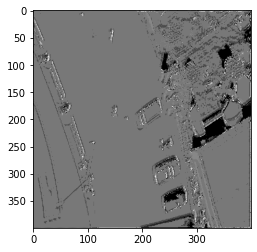

In [ ]:
print(item)

plt.imshow(item, cmap="gray")
plt.show()